<a href="https://colab.research.google.com/github/makimeeow/MovieRating/blob/main/MLCC_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Notes:
  # both_results_df
  # ses_results_df
  # env_results_df

# Pre-Processing

In [ ]:
data = pd.read_csv('/content/drive/My Drive/MLCC Final Project Code/hvi_final_data.csv')
data.head(20)

,zipcode,borough,neighborhood,population,average_building_area,res_units_per_capita,mean_energy_star_score_50k_building,electricity_onsite_renew_per_50k_building,green_power_onsite_per_50k_building,nat_gas_onsite_per_50k_building,num_trees,total_acres_greenstreets,num_community_gardens,white_percent,black_percent,poverty_percent,college_percent,jail_admissions_per_100k,income_group,hvi
0,10001,MN,Hudson Yards-Chelsea-Flatiron-Union Square,25026,103343.274491,0.892592,68.485955,49.059266,49.059266,52827.811009,850,0.153439,0,0.51,0.07,0.1108,0.715,23.0,1,2
1,10002,MN,Chinatown,74363,24391.539553,0.495515,55.617978,0.000000,0.000000,53397.614343,2158,2.862656,624,0.23,0.07,0.1314,0.389,91.0,0,3
2,10003,MN,East Village,54671,27389.530400,0.615482,58.038462,0.000000,0.000000,30035.292308,1943,0.446423,218,0.65,0.05,0.0804,0.822,17.0,1,2
3,10004,MN,Battery Park City-Lower Manhattan,3310,115721.219081,1.032326,62.255319,0.000000,0.000000,6150.926087,117,0.000000,1,0.56,0.03,0.0737,0.909,0.0,2,1
4,10005,MN,Battery Park City-Lower Manhattan,8664,383097.061538,0.793052,56.209302,0.000000,0.000000,4959.997826,130,0.000000,4,0.72,0.02,0.1020,0.843,0.0,2,1
5,10006,MN,Battery Park City-Lower Manhattan,3260,189312.723077,1.150920,58.878788,0.000000,0.000000,4917.506550,48,0.127659,5,0.59,0.07,0.1049,0.849,0.0,2,1
6,10007,MN,SoHo-TriBeCa-Civic Center-Little Italy,7566,157373.058594,0.638514,57.928571,43.414945,0.000000,6262.520220,338,0.107814,6,0.66,0.09,0.2159,0.864,1.0,2,1
7,10009,MN,Lower East Side,58267,21430.972335,0.586610,59.048077,12175.716814,12175.716814,26062.911283,1854,0.399529,3590,0.49,0.06,0.1059,0.626,46.0,1,2
8,10010,MN,Gramercy,34763,67917.319767,0.583436,65.746411,4092.057788,4092.057788,19902.154628,841,0.545071,38,0.61,0.09,0.1376,0.805,4.0,2,1
9,10011,MN,Hudson Yards-Chelsea-Flatiron-Union Square,50228,26756.917147,0.680756,62.161290,311.009751,298.500680,33916.918367,2040,0.105829,210,0.66,0.04,0.0912,0.792,10.0,2,1


In [ ]:
data.shape

(173, 20)

In [ ]:
data['electricity_onsite_renew_per_50k_building'].value_counts()

,count
electricity_onsite_renew_per_50k_building,
0.000000e+00,95
4.905927e+01,1
4.341495e+01,1
1.217572e+04,1
4.092058e+03,1
...,...
1.593295e+06,1
1.621194e+05,1
3.530770e+04,1


In [ ]:
data['green_power_onsite_per_50k_building'].value_counts()

,count
green_power_onsite_per_50k_building,
0.000000,112
49.059266,1
12175.716814,1
4092.057788,1
298.500680,1
...,...
249666.300000,1
160952.800000,1
35307.700000,1


In [ ]:
data = data.drop(['electricity_onsite_renew_per_50k_building', 'green_power_onsite_per_50k_building'], axis=1) # have too many 0 values

In [ ]:
data['hvi'].value_counts()

,count
hvi,
4,37
5,37
2,35
3,33
1,31


In [ ]:
# pd.plotting.scatter_matrix(data, figsize=(40, 40), color = 'cornflowerblue')

# Models using all features

In [ ]:
# define helper functions

def get_avg_per_class_accuracy(model, X, y, kfold):
    class_acc = defaultdict(list)
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        for cls in class_labels:
            class_str = str(cls)
            if class_str in report:
                class_acc[class_str].append(report[class_str]['recall'])  # recall = accuracy per class
    return {cls: np.mean(scores) for cls, scores in class_acc.items()}


def get_avg_per_class_auroc(model, X, y, kfold, class_labels):
    per_class_aucs = defaultdict(list)
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        y_bin = label_binarize(y_test, classes=class_labels)

        for i, cls in enumerate(class_labels):
            try:
                auc = roc_auc_score(y_bin[:, i], y_score[:, i])
                per_class_aucs[str(cls)].append(auc)
            except ValueError:
                continue  # Skip class if not present in this fold
    return {cls: np.mean(scores) for cls, scores in per_class_aucs.items()}

In [ ]:
# using all features (minus string columns & population because not intended to be predictors)
X = data.drop(['hvi', 'borough', 'zipcode', 'neighborhood', 'population'], axis=1)
y = data['hvi'] - 1
class_labels = np.unique(y)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'logisticregression__C': [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'randomforestclassifier__n_estimators': [50, 100],
        'randomforestclassifier__max_depth': [None, 10, 20]
    },
    "LightGBM": {
        'lgbmclassifier__num_leaves': [31, 50],
        'lgbmclassifier__learning_rate': [0.05, 0.1]
    },
    "XGBoost": {
        'xgbclassifier__max_depth': [3, 6],
        'xgbclassifier__learning_rate': [0.05, 0.1]
    }
}

for name, model in models.items():
    print(f"\nEvaluating {name} with Grid Search...")
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")



Evaluating Logistic Regression with Grid Search...
Best params for Logistic Regression: {'logisticregression__C': 1}

Evaluating Decision Tree with Grid Search...
Best params for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}

Evaluating Random Forest with Grid Search...
Best params for Random Forest: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 50}

Evaluating LightGBM with Grid Search...
Best params for LightGBM: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__num_leaves': 31}

Evaluating XGBoost with Grid Search...
Best params for XGBoost: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3}


In [ ]:
# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1, max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=2, class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(learning_rate=0.1, num_leaves=31, objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(learning_rate=0.1, max_depth=3, objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Store results
results_acc = {}
results_auc = {}
results_mse = {}
per_class_acc_results = {}
per_class_auc_results = {}
all_per_class_acc_results = []
all_per_class_auc_results = []

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Accuracy
    acc_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results_acc[name] = (np.mean(acc_scores), np.std(acc_scores))

    # AUROC (OvR)
    auc_scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc_ovr')
    results_auc[name] = (np.mean(auc_scores), np.std(auc_scores))

    # MSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results_mse[name] = (-mse_scores.mean(), mse_scores.std())

    # Per-class Accuracy
    avg_class_acc = get_avg_per_class_accuracy(model, X.to_numpy(), y.to_numpy(), kfold)
    per_class_acc_results[name] = avg_class_acc

    # Per-class AUROC
    avg_class_auc = get_avg_per_class_auroc(model, X.to_numpy(), y.to_numpy(), kfold, class_labels)
    per_class_auc_results[name] = avg_class_auc

    print(f"Per-class Accuracy: {avg_class_acc}")
    all_per_class_acc_results.append(avg_class_acc)
    print(f"Per-class AUROC: {avg_class_auc}")
    all_per_class_auc_results.append(avg_class_auc)

# Summary
print("\nModel Accuracy Results")
for name, (mean_score, std_score) in results_acc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel AUROC Results")
for name, (mean_score, std_score) in results_auc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel MSE Results")
for name, (mean_score, std_score) in results_mse.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")



Evaluating Logistic Regression...
Per-class Accuracy: {'0': np.float64(0.6380952380952382), '1': np.float64(0.5714285714285714), '2': np.float64(0.3952380952380952), '3': np.float64(0.4321428571428571), '4': np.float64(0.8928571428571429)}
Per-class AUROC: {'0': np.float64(0.8890166028097063), '1': np.float64(0.8562358276643991), '2': np.float64(0.7608843537414967), '3': np.float64(0.756840513983371), '4': np.float64(0.9485275306703878)}

Evaluating Decision Tree...
Per-class Accuracy: {'0': np.float64(0.5047619047619047), '1': np.float64(0.5142857142857142), '2': np.float64(0.6666666666666666), '3': np.float64(0.23571428571428568), '4': np.float64(0.6785714285714286)}
Per-class AUROC: {'0': np.float64(0.8295748950921364), '1': np.float64(0.7431972789115646), '2': np.float64(0.7122448979591837), '3': np.float64(0.6141817838246411), '4': np.float64(0.8433629862201292)}

Evaluating Random Forest...
Per-class Accuracy: {'0': np.float64(0.619047619047619), '1': np.float64(0.6), '2': np.fl

In [ ]:
# Build a unified summary DataFrame from the stored results
summary_rows = []

for model_name in models.keys():
    row = {
        'model': model_name,
        'overall_acc': results_acc[model_name][0],
        'overall_acc_std': results_acc[model_name][1],
        'overall_auroc': results_auc[model_name][0],
        'overall_auroc_std': results_auc[model_name][1],
        'mse': results_mse[model_name][0],
        'mse_std': results_mse[model_name][1],
    }
    summary_rows.append(row)

# Create final summary DataFrame
all_results_df = pd.DataFrame(summary_rows)

all_per_class_acc_results_df = pd.DataFrame(all_per_class_acc_results)
all_per_class_acc_results_df.columns = ['class_1_acc', 'class_2_acc', 'class_3_acc', 'class_4_acc', 'class_5_acc']
all_per_class_auc_results_df = pd.DataFrame(all_per_class_auc_results)
all_per_class_auc_results_df.columns = ['class_1_auc', 'class_2_auc', 'class_3_auc', 'class_4_auc', 'class_5_auc']

all_results_df = pd.concat([all_results_df, all_per_class_acc_results_df, all_per_class_auc_results_df], axis=1)

In [ ]:
all_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.589244,0.080326,0.842301,0.045000,0.884538,0.211879,0.638095,0.571429,0.395238,0.432143,0.892857,0.889017,0.856236,0.760884,0.756841,0.948528
1,Decision Tree,0.519832,0.077547,0.748512,0.029191,0.931765,0.219629,0.504762,0.514286,0.666667,0.235714,0.678571,0.829575,0.743197,0.712245,0.614182,0.843363
2,Random Forest,0.601345,0.078415,0.849186,0.007820,0.759496,0.184035,0.619048,0.600000,0.485714,0.460714,0.842857,0.885044,0.849773,0.807653,0.752589,0.950872
3,LightGBM,0.618824,0.042867,0.845078,0.017271,0.792941,0.159161,0.704762,0.685714,0.457143,0.428571,0.807143,0.873385,0.860506,0.808673,0.752948,0.929875
4,XGBoost,0.601345,0.025141,0.850787,0.016671,0.828067,0.178715,0.738095,0.571429,0.390476,0.492857,0.817857,0.901067,0.855896,0.806463,0.754951,0.935560


In [ ]:
# Define a feedforward neural network
class NeuralNetwork(nn.Module):
   def __init__(self, input_dim):
       super(NeuralNetwork, self).__init__()
       self.fc1 = nn.Linear(input_dim, 32)
       self.relu = nn.ReLU()
       self.fc2 = nn.Linear(32, 1)


   def forward(self, x):
       x = self.relu(self.fc1(x))
       return self.fc2(x)

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_np = X_scaled
y_np = y.to_numpy()

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Track metrics
all_fold_metrics = []
all_nn_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_np, y_np)):

    # Prepare train/test tensors and move to device
    X_train = torch.tensor(X_np[train_idx], dtype=torch.float32).to(device)
    y_train = torch.tensor(y_np[train_idx], dtype=torch.float32).view(-1, 1).to(device)
    X_val = torch.tensor(X_np[val_idx], dtype=torch.float32).to(device)
    y_val = torch.tensor(y_np[val_idx], dtype=torch.float32).view(-1, 1).to(device)

    # Initialize model per fold
    model = NeuralNetwork(input_dim=X_np.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        raw_preds = model(X_val.to(device)).cpu().numpy().flatten()
        preds = np.clip(np.round(raw_preds), 0, 4).astype(int)
        y_true = y_val.cpu().numpy().flatten().astype(int)

    # AUROC
    y_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    raw_preds_bin = np.tile(raw_preds.reshape(-1, 1), y_bin.shape[1])
    aucs = {}
    for i, cls in enumerate([0, 1, 2, 3, 4]):
        try:
            aucs[str(cls)] = roc_auc_score(y_bin[:, i], raw_preds_bin[:, i])
        except ValueError:
            aucs[str(cls)] = None

    # Metrics
    acc = accuracy_score(y_true, preds)
    try:
      auc = roc_auc_score(y_bin, raw_preds_bin, average='macro')
    except ValueError:
      auc = None  # Happens if a class is missing in y_val
    mse = mean_squared_error(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)


    # Save fold metrics
    fold_result = {
        'fold': fold + 1,
        'accuracy': acc,
        'auc' : auc,
        'mse': mse,
        'per_class_accuracy': {cls: report[str(cls)]['recall'] for cls in report if cls.isdigit()},
        'per_class_auroc': aucs
    }
    all_fold_metrics.append(fold_result)


In [ ]:
def summarize_fold_results(all_fold_metrics):
    from collections import defaultdict

    metrics = {
        'accuracy': [],
        'auc': [],
        'mse': [],
        'per_class_accuracy': defaultdict(list),
        'per_class_auroc': defaultdict(list)
    }



    for result in all_fold_metrics:
        metrics['accuracy'].append(result['accuracy'])
        if result['auc'] is not None:
            metrics['auc'].append(result['auc'])
        metrics['mse'].append(result['mse'])

        for cls, val in result['per_class_accuracy'].items():
            metrics['per_class_accuracy'][int(cls)].append(val)
        for cls, val in result['per_class_auroc'].items():
            if val is not None:
                metrics['per_class_auroc'][int(cls)].append(val)

    # Final result list: [model, acc, acc_std, auroc, auroc_std, mse, mse_std, acc_class_0..4, auc_class_0..4]
    all_nn_results = [
        "Neural Network",                             # model name
        np.mean(metrics['accuracy']),                # overall_acc
        np.std(metrics['accuracy']),                 # overall_acc_std
        np.mean(metrics['auc']),                     # overall_auroc
        np.std(metrics['auc']),                      # overall_auroc_std
        np.mean(metrics['mse']),                     # mse
        np.std(metrics['mse'])                       # mse_std
    ]

    # Per-class accuracy
    for cls in range(5):
        acc_scores = metrics['per_class_accuracy'].get(cls, [np.nan])
        all_nn_results.append(np.mean(acc_scores))

    # Per-class AUROC
    for cls in range(5):
        auc_scores = metrics['per_class_auroc'].get(cls, [np.nan])
        all_nn_results.append(np.mean(auc_scores))

    # Define columns
    columns = (
        ['model', 'overall_acc', 'overall_acc_std', 'overall_auroc', 'overall_auroc_std', 'mse', 'mse_std'] +
        [f'class_{i + 1}_acc' for i in range(5)] +
        [f'class_{i + 1}_auc' for i in range(5)]
    )

    # Create dataframe
    nn_df = pd.DataFrame([all_nn_results], columns=columns)
    print("\n=== Cross-Validated Neural Network Summary ===")
    print(nn_df)

    return nn_df


In [ ]:
all_nn_results_df = summarize_fold_results(all_fold_metrics)
all_nn_results_df.head()


=== Cross-Validated Neural Network Summary ===
            model  overall_acc  overall_acc_std  overall_auroc  \
0  Neural Network     0.496807         0.033628       0.489104   

   overall_auroc_std       mse   mse_std  class_1_acc  class_2_acc  \
0           0.006613  0.712941  0.140734     0.190476          0.8   

   class_3_acc  class_4_acc  class_5_acc  class_1_auc  class_2_auc  \
0      0.47619     0.378571     0.596429     0.167816     0.191988   

   class_3_auc  class_4_auc  class_5_auc  
0     0.467347     0.672751     0.945617  


,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Neural Network,0.496807,0.033628,0.489104,0.006613,0.712941,0.140734,0.190476,0.8,0.47619,0.378571,0.596429,0.167816,0.191988,0.467347,0.672751,0.945617


In [ ]:
all_results_df = pd.concat([all_results_df, all_nn_results_df], ignore_index=True)
both_results_df = all_results_df
both_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.589244,0.080326,0.842301,0.045000,0.884538,0.211879,0.638095,0.571429,0.395238,0.432143,0.892857,0.889017,0.856236,0.760884,0.756841,0.948528
1,Decision Tree,0.519832,0.077547,0.748512,0.029191,0.931765,0.219629,0.504762,0.514286,0.666667,0.235714,0.678571,0.829575,0.743197,0.712245,0.614182,0.843363
2,Random Forest,0.601345,0.078415,0.849186,0.007820,0.759496,0.184035,0.619048,0.600000,0.485714,0.460714,0.842857,0.885044,0.849773,0.807653,0.752589,0.950872
3,LightGBM,0.618824,0.042867,0.845078,0.017271,0.792941,0.159161,0.704762,0.685714,0.457143,0.428571,0.807143,0.873385,0.860506,0.808673,0.752948,0.929875
4,XGBoost,0.601345,0.025141,0.850787,0.016671,0.828067,0.178715,0.738095,0.571429,0.390476,0.492857,0.817857,0.901067,0.855896,0.806463,0.754951,0.935560
5,Neural Network,0.496807,0.033628,0.489104,0.006613,0.712941,0.140734,0.190476,0.800000,0.476190,0.378571,0.596429,0.167816,0.191988,0.467347,0.672751,0.945617


# Models using only socioeconomic features

In [ ]:
# using all socioeconomic features (also not the string columns & population because not intended to be predictors)
X = data[['white_percent', 'black_percent', 'poverty_percent', 'college_percent', 'jail_admissions_per_100k', 'income_group']]
y = data['hvi'] - 1
class_labels = np.unique(y)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'logisticregression__C': [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'randomforestclassifier__n_estimators': [50, 100],
        'randomforestclassifier__max_depth': [None, 10, 20]
    },
    "LightGBM": {
        'lgbmclassifier__num_leaves': [31, 50],
        'lgbmclassifier__learning_rate': [0.05, 0.1]
    },
    "XGBoost": {
        'xgbclassifier__max_depth': [3, 6],
        'xgbclassifier__learning_rate': [0.05, 0.1]
    }
}

for name, model in models.items():
    print(f"\nEvaluating {name} with Grid Search...")
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")



Evaluating Logistic Regression with Grid Search...
Best params for Logistic Regression: {'logisticregression__C': 0.1}

Evaluating Decision Tree with Grid Search...
Best params for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}

Evaluating Random Forest with Grid Search...
Best params for Random Forest: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 50}

Evaluating LightGBM with Grid Search...
Best params for LightGBM: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__num_leaves': 31}

Evaluating XGBoost with Grid Search...
Best params for XGBoost: {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 6}


In [ ]:
# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(C=0.1, max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10, class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(learning_rate=0.1, num_leaves=31, objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(learning_rate=0.05, max_depth=6, objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Store results
results_acc = {}
results_auc = {}
results_mse = {}
per_class_acc_results = {}
per_class_auc_results = {}
all_per_class_acc_results = []
all_per_class_auc_results = []

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Accuracy
    acc_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results_acc[name] = (np.mean(acc_scores), np.std(acc_scores))

    # AUROC (OvR)
    auc_scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc_ovr')
    results_auc[name] = (np.mean(auc_scores), np.std(auc_scores))

    # MSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results_mse[name] = (-mse_scores.mean(), mse_scores.std())

    # Per-class Accuracy
    avg_class_acc = get_avg_per_class_accuracy(model, X.to_numpy(), y.to_numpy(), kfold)
    per_class_acc_results[name] = avg_class_acc

    # Per-class AUROC
    avg_class_auc = get_avg_per_class_auroc(model, X.to_numpy(), y.to_numpy(), kfold, class_labels)
    per_class_auc_results[name] = avg_class_auc

    print(f"Per-class Accuracy: {avg_class_acc}")
    all_per_class_acc_results.append(avg_class_acc)
    print(f"Per-class AUROC: {avg_class_auc}")
    all_per_class_auc_results.append(avg_class_auc)

# Summary
print("\nModel Accuracy Results")
for name, (mean_score, std_score) in results_acc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel AUROC Results")
for name, (mean_score, std_score) in results_auc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel MSE Results")
for name, (mean_score, std_score) in results_mse.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")



Evaluating Logistic Regression...
Per-class Accuracy: {'0': np.float64(0.7428571428571429), '1': np.float64(0.3428571428571428), '2': np.float64(0.42857142857142855), '3': np.float64(0.32857142857142857), '4': np.float64(0.8928571428571429)}
Per-class AUROC: {'0': np.float64(0.8798120780879402), '1': np.float64(0.825018896447468), '2': np.float64(0.7841836734693877), '3': np.float64(0.7605820105820106), '4': np.float64(0.950906302692017)}

Evaluating Decision Tree...
Per-class Accuracy: {'0': np.float64(0.4523809523809524), '1': np.float64(0.5428571428571428), '2': np.float64(0.36190476190476184), '3': np.float64(0.45714285714285713), '4': np.float64(0.7571428571428572)}
Per-class AUROC: {'0': np.float64(0.736767925561029), '1': np.float64(0.7303476946334089), '2': np.float64(0.6637755102040817), '3': np.float64(0.6354497354497355), '4': np.float64(0.8749578463864178)}

Evaluating Random Forest...
Per-class Accuracy: {'0': np.float64(0.5761904761904761), '1': np.float64(0.514285714285

In [ ]:
# Build a unified summary DataFrame from the stored results
summary_rows = []

for model_name in models.keys():
    row = {
        'model': model_name,
        'overall_acc': results_acc[model_name][0],
        'overall_acc_std': results_acc[model_name][1],
        'overall_auroc': results_auc[model_name][0],
        'overall_auroc_std': results_auc[model_name][1],
        'mse': results_mse[model_name][0],
        'mse_std': results_mse[model_name][1],
    }
    summary_rows.append(row)

# Create final summary DataFrame
all_results_df = pd.DataFrame(summary_rows)

all_per_class_acc_results_df = pd.DataFrame(all_per_class_acc_results)
all_per_class_acc_results_df.columns = ['class_1_acc', 'class_2_acc', 'class_3_acc', 'class_4_acc', 'class_5_acc']
all_per_class_auc_results_df = pd.DataFrame(all_per_class_auc_results)
all_per_class_auc_results_df.columns = ['class_1_auc', 'class_2_auc', 'class_3_auc', 'class_4_auc', 'class_5_auc']

all_results_df = pd.concat([all_results_df, all_per_class_acc_results_df, all_per_class_auc_results_df], axis=1)

In [ ]:
all_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.543529,0.062258,0.840101,0.027446,0.913613,0.187898,0.742857,0.342857,0.428571,0.328571,0.892857,0.879812,0.825019,0.784184,0.760582,0.950906
1,Decision Tree,0.519328,0.075656,0.728260,0.049771,0.846387,0.291970,0.452381,0.542857,0.361905,0.457143,0.757143,0.736768,0.730348,0.663776,0.635450,0.874958
2,Random Forest,0.549076,0.038960,0.828035,0.012437,0.881345,0.261969,0.576190,0.514286,0.423810,0.432143,0.785714,0.873965,0.789739,0.789031,0.732228,0.955210
3,LightGBM,0.548908,0.048983,0.840383,0.033434,0.879664,0.193078,0.647619,0.485714,0.361905,0.407143,0.839286,0.874799,0.829025,0.784694,0.767347,0.946978
4,XGBoost,0.543361,0.009321,0.828946,0.027809,0.933277,0.275815,0.638095,0.514286,0.419048,0.407143,0.735714,0.879839,0.794482,0.770748,0.756595,0.943064


In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_np = X_scaled
y_np = y.to_numpy()

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Track metrics
all_fold_metrics = []
all_nn_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_np, y_np)):

    # Prepare train/test tensors and move to device
    X_train = torch.tensor(X_np[train_idx], dtype=torch.float32).to(device)
    y_train = torch.tensor(y_np[train_idx], dtype=torch.float32).view(-1, 1).to(device)
    X_val = torch.tensor(X_np[val_idx], dtype=torch.float32).to(device)
    y_val = torch.tensor(y_np[val_idx], dtype=torch.float32).view(-1, 1).to(device)

    # Initialize model per fold
    model = NeuralNetwork(input_dim=X_np.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        raw_preds = model(X_val.to(device)).cpu().numpy().flatten()
        preds = np.clip(np.round(raw_preds), 0, 4).astype(int)
        y_true = y_val.cpu().numpy().flatten().astype(int)

    # AUROC
    y_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    raw_preds_bin = np.tile(raw_preds.reshape(-1, 1), y_bin.shape[1])
    aucs = {}
    for i, cls in enumerate([0, 1, 2, 3, 4]):
        try:
            aucs[str(cls)] = roc_auc_score(y_bin[:, i], raw_preds_bin[:, i])
        except ValueError:
            aucs[str(cls)] = None

    # Metrics
    acc = accuracy_score(y_true, preds)
    try:
      auc = roc_auc_score(y_bin, raw_preds_bin, average='macro')
    except ValueError:
      auc = None  # Happens if a class is missing in y_val
    mse = mean_squared_error(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)


    # Save fold metrics
    fold_result = {
        'fold': fold + 1,
        'accuracy': acc,
        'auc' : auc,
        'mse': mse,
        'per_class_accuracy': {cls: report[str(cls)]['recall'] for cls in report if cls.isdigit()},
        'per_class_auroc': aucs
    }
    all_fold_metrics.append(fold_result)


In [ ]:
all_nn_results_df = summarize_fold_results(all_fold_metrics)
all_nn_results_df.head()


=== Cross-Validated Neural Network Summary ===
            model  overall_acc  overall_acc_std  overall_auroc  \
0  Neural Network     0.462185         0.060728       0.488418   

   overall_auroc_std       mse   mse_std  class_1_acc  class_2_acc  \
0           0.006762  0.713277  0.176134          0.2          0.8   

   class_3_acc  class_4_acc  class_5_acc  class_1_auc  class_2_auc  \
0     0.519048        0.325     0.460714       0.1302     0.213228   

   class_3_auc  class_4_auc  class_5_auc  
0     0.472279     0.689815      0.93657  


,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Neural Network,0.462185,0.060728,0.488418,0.006762,0.713277,0.176134,0.2,0.8,0.519048,0.325,0.460714,0.1302,0.213228,0.472279,0.689815,0.93657


In [ ]:
all_results_df = pd.concat([all_results_df, all_nn_results_df], ignore_index=True)
ses_results_df = all_results_df
ses_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.543529,0.062258,0.840101,0.027446,0.913613,0.187898,0.742857,0.342857,0.428571,0.328571,0.892857,0.879812,0.825019,0.784184,0.760582,0.950906
1,Decision Tree,0.519328,0.075656,0.728260,0.049771,0.846387,0.291970,0.452381,0.542857,0.361905,0.457143,0.757143,0.736768,0.730348,0.663776,0.635450,0.874958
2,Random Forest,0.549076,0.038960,0.828035,0.012437,0.881345,0.261969,0.576190,0.514286,0.423810,0.432143,0.785714,0.873965,0.789739,0.789031,0.732228,0.955210
3,LightGBM,0.548908,0.048983,0.840383,0.033434,0.879664,0.193078,0.647619,0.485714,0.361905,0.407143,0.839286,0.874799,0.829025,0.784694,0.767347,0.946978
4,XGBoost,0.543361,0.009321,0.828946,0.027809,0.933277,0.275815,0.638095,0.514286,0.419048,0.407143,0.735714,0.879839,0.794482,0.770748,0.756595,0.943064
5,Neural Network,0.462185,0.060728,0.488418,0.006762,0.713277,0.176134,0.200000,0.800000,0.519048,0.325000,0.460714,0.130200,0.213228,0.472279,0.689815,0.936570


# Models using only environmental features

In [ ]:
# using only environmental features (also not string columns & population because not intended to be predictors)
X = data.drop(['hvi', 'borough', 'zipcode', 'neighborhood', 'population', 'white_percent', 'black_percent', 'poverty_percent', 'college_percent', 'jail_admissions_per_100k', 'income_group'], axis=1)
y = data['hvi'] - 1
class_labels = np.unique(y)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'logisticregression__C': [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'randomforestclassifier__n_estimators': [50, 100],
        'randomforestclassifier__max_depth': [None, 10, 20]
    },
    "LightGBM": {
        'lgbmclassifier__num_leaves': [31, 50],
        'lgbmclassifier__learning_rate': [0.05, 0.1]
    },
    "XGBoost": {
        'xgbclassifier__max_depth': [3, 6],
        'xgbclassifier__learning_rate': [0.05, 0.1]
    }
}

for name, model in models.items():
    print(f"\nEvaluating {name} with Grid Search...")
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")



Evaluating Logistic Regression with Grid Search...
Best params for Logistic Regression: {'logisticregression__C': 1}

Evaluating Decision Tree with Grid Search...
Best params for Decision Tree: {'max_depth': None, 'min_samples_split': 2}

Evaluating Random Forest with Grid Search...
Best params for Random Forest: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 50}

Evaluating LightGBM with Grid Search...
Best params for LightGBM: {'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__num_leaves': 31}

Evaluating XGBoost with Grid Search...
Best params for XGBoost: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3}


In [ ]:
# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1, max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(max_depth=None, n_estimators=50, random_state=42)
    ),
    "LightGBM": make_pipeline(
        StandardScaler(),
        LGBMClassifier(learning_rate=0.05, num_leaves=31, objective='multiclass', num_class=len(class_labels), verbose=-1, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(learning_rate=0.1, max_depth=3, objective='multi:softprob', num_class=len(class_labels),
                      use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    )
}

# Store results
results_acc = {}
results_auc = {}
results_mse = {}
per_class_acc_results = {}
per_class_auc_results = {}
all_per_class_acc_results = []
all_per_class_auc_results = []

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Accuracy
    acc_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results_acc[name] = (np.mean(acc_scores), np.std(acc_scores))

    # AUROC (OvR)
    auc_scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc_ovr')
    results_auc[name] = (np.mean(auc_scores), np.std(auc_scores))

    # MSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results_mse[name] = (-mse_scores.mean(), mse_scores.std())

    # Per-class Accuracy
    avg_class_acc = get_avg_per_class_accuracy(model, X.to_numpy(), y.to_numpy(), kfold)
    per_class_acc_results[name] = avg_class_acc

    # Per-class AUROC
    avg_class_auc = get_avg_per_class_auroc(model, X.to_numpy(), y.to_numpy(), kfold, class_labels)
    per_class_auc_results[name] = avg_class_auc

    print(f"Per-class Accuracy: {avg_class_acc}")
    all_per_class_acc_results.append(avg_class_acc)
    print(f"Per-class AUROC: {avg_class_auc}")
    all_per_class_auc_results.append(avg_class_auc)

# Summary
print("\nModel Accuracy Results")
for name, (mean_score, std_score) in results_acc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel AUROC Results")
for name, (mean_score, std_score) in results_auc.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

print("\nModel MSE Results")
for name, (mean_score, std_score) in results_mse.items():
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")



Evaluating Logistic Regression...
Per-class Accuracy: {'0': np.float64(0.4095238095238095), '1': np.float64(0.42857142857142855), '2': np.float64(0.4619047619047619), '3': np.float64(0.2678571428571429), '4': np.float64(0.4892857142857143)}
Per-class AUROC: {'0': np.float64(0.7911056376573617), '1': np.float64(0.725434618291761), '2': np.float64(0.6858843537414966), '3': np.float64(0.6293083900226757), '4': np.float64(0.7041172451886737)}

Evaluating Decision Tree...
Per-class Accuracy: {'0': np.float64(0.4809523809523809), '1': np.float64(0.42857142857142855), '2': np.float64(0.3571428571428571), '3': np.float64(0.4892857142857142), '4': np.float64(0.525)}
Per-class AUROC: {'0': np.float64(0.6951377485860244), '1': np.float64(0.6304232804232804), '2': np.float64(0.6214285714285714), '3': np.float64(0.6671296296296296), '4': np.float64(0.6856176231176232)}

Evaluating Random Forest...
Per-class Accuracy: {'0': np.float64(0.4809523809523809), '1': np.float64(0.42857142857142855), '2': 

In [ ]:
# Build a unified summary DataFrame from the stored results
summary_rows = []

for model_name in models.keys():
    row = {
        'model': model_name,
        'overall_acc': results_acc[model_name][0],
        'overall_acc_std': results_acc[model_name][1],
        'overall_auroc': results_auc[model_name][0],
        'overall_auroc_std': results_auc[model_name][1],
        'mse': results_mse[model_name][0],
        'mse_std': results_mse[model_name][1],
    }
    summary_rows.append(row)

# Create final summary DataFrame
all_results_df = pd.DataFrame(summary_rows)

all_per_class_acc_results_df = pd.DataFrame(all_per_class_acc_results)
all_per_class_acc_results_df.columns = ['class_1_acc', 'class_2_acc', 'class_3_acc', 'class_4_acc', 'class_5_acc']
all_per_class_auc_results_df = pd.DataFrame(all_per_class_auc_results)
all_per_class_auc_results_df.columns = ['class_1_auc', 'class_2_auc', 'class_3_auc', 'class_4_auc', 'class_5_auc']

all_results_df = pd.concat([all_results_df, all_per_class_acc_results_df, all_per_class_auc_results_df], axis=1)

In [ ]:
all_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.410756,0.100898,0.707170,0.072447,1.800672,0.869391,0.409524,0.428571,0.461905,0.267857,0.489286,0.791106,0.725435,0.685884,0.629308,0.704117
1,Decision Tree,0.455966,0.067134,0.659947,0.042613,1.923361,0.549481,0.480952,0.428571,0.357143,0.489286,0.525000,0.695138,0.630423,0.621429,0.667130,0.685618
2,Random Forest,0.479496,0.029893,0.766539,0.030216,1.767227,0.383966,0.480952,0.428571,0.433333,0.485714,0.578571,0.779513,0.768764,0.715901,0.740505,0.828013
3,LightGBM,0.444538,0.071277,0.736567,0.048340,2.376303,0.577422,0.414286,0.428571,0.338095,0.514286,0.517857,0.777185,0.740892,0.667517,0.722846,0.774395
4,XGBoost,0.473445,0.084409,0.747499,0.057847,1.988571,0.518267,0.552381,0.457143,0.300000,0.435714,0.628571,0.788342,0.745427,0.708503,0.702721,0.792503


In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_np = X_scaled
y_np = y.to_numpy()

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Track metrics
all_fold_metrics = []
all_nn_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_np, y_np)):

    # Prepare train/test tensors and move to device
    X_train = torch.tensor(X_np[train_idx], dtype=torch.float32).to(device)
    y_train = torch.tensor(y_np[train_idx], dtype=torch.float32).view(-1, 1).to(device)
    X_val = torch.tensor(X_np[val_idx], dtype=torch.float32).to(device)
    y_val = torch.tensor(y_np[val_idx], dtype=torch.float32).view(-1, 1).to(device)

    # Initialize model per fold
    model = NeuralNetwork(input_dim=X_np.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        raw_preds = model(X_val.to(device)).cpu().numpy().flatten()
        preds = np.clip(np.round(raw_preds), 0, 4).astype(int)
        y_true = y_val.cpu().numpy().flatten().astype(int)

    # AUROC
    y_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    raw_preds_bin = np.tile(raw_preds.reshape(-1, 1), y_bin.shape[1])
    aucs = {}
    for i, cls in enumerate([0, 1, 2, 3, 4]):
        try:
            aucs[str(cls)] = roc_auc_score(y_bin[:, i], raw_preds_bin[:, i])
        except ValueError:
            aucs[str(cls)] = None

    # Metrics
    acc = accuracy_score(y_true, preds)
    try:
      auc = roc_auc_score(y_bin, raw_preds_bin, average='macro')
    except ValueError:
      auc = None  # Happens if a class is missing in y_val
    mse = mean_squared_error(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)


    # Save fold metrics
    fold_result = {
        'fold': fold + 1,
        'accuracy': acc,
        'auc' : auc,
        'mse': mse,
        'per_class_accuracy': {cls: report[str(cls)]['recall'] for cls in report if cls.isdigit()},
        'per_class_auroc': aucs
    }
    all_fold_metrics.append(fold_result)


In [ ]:
all_nn_results_df = summarize_fold_results(all_fold_metrics)
all_nn_results_df.head()


=== Cross-Validated Neural Network Summary ===
            model  overall_acc  overall_acc_std  overall_auroc  \
0  Neural Network     0.243025         0.050981       0.494442   

   overall_auroc_std       mse   mse_std  class_1_acc  class_2_acc  \
0           0.004743  1.716807  0.312256     0.033333     0.314286   

   class_3_acc  class_4_acc  class_5_acc  class_1_auc  class_2_auc  \
0     0.671429        0.225          0.0     0.280332     0.262736   

   class_3_auc  class_4_auc  class_5_auc  
0     0.610034     0.664342     0.654766  


,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Neural Network,0.243025,0.050981,0.494442,0.004743,1.716807,0.312256,0.033333,0.314286,0.671429,0.225,0.0,0.280332,0.262736,0.610034,0.664342,0.654766


In [ ]:
all_results_df = pd.concat([all_results_df, all_nn_results_df], ignore_index=True)
env_results_df = all_results_df
env_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.410756,0.100898,0.707170,0.072447,1.800672,0.869391,0.409524,0.428571,0.461905,0.267857,0.489286,0.791106,0.725435,0.685884,0.629308,0.704117
1,Decision Tree,0.455966,0.067134,0.659947,0.042613,1.923361,0.549481,0.480952,0.428571,0.357143,0.489286,0.525000,0.695138,0.630423,0.621429,0.667130,0.685618
2,Random Forest,0.479496,0.029893,0.766539,0.030216,1.767227,0.383966,0.480952,0.428571,0.433333,0.485714,0.578571,0.779513,0.768764,0.715901,0.740505,0.828013
3,LightGBM,0.444538,0.071277,0.736567,0.048340,2.376303,0.577422,0.414286,0.428571,0.338095,0.514286,0.517857,0.777185,0.740892,0.667517,0.722846,0.774395
4,XGBoost,0.473445,0.084409,0.747499,0.057847,1.988571,0.518267,0.552381,0.457143,0.300000,0.435714,0.628571,0.788342,0.745427,0.708503,0.702721,0.792503
5,Neural Network,0.243025,0.050981,0.494442,0.004743,1.716807,0.312256,0.033333,0.314286,0.671429,0.225000,0.000000,0.280332,0.262736,0.610034,0.664342,0.654766


# Feature importance

In [ ]:
both_results_df.head(10)

,model,overall_acc,overall_acc_std,overall_auroc,overall_auroc_std,mse,mse_std,class_1_acc,class_2_acc,class_3_acc,class_4_acc,class_5_acc,class_1_auc,class_2_auc,class_3_auc,class_4_auc,class_5_auc
0,Logistic Regression,0.589244,0.080326,0.842301,0.045000,0.884538,0.211879,0.638095,0.571429,0.395238,0.432143,0.892857,0.889017,0.856236,0.760884,0.756841,0.948528
1,Decision Tree,0.519832,0.077547,0.748512,0.029191,0.931765,0.219629,0.504762,0.514286,0.666667,0.235714,0.678571,0.829575,0.743197,0.712245,0.614182,0.843363
2,Random Forest,0.601345,0.078415,0.849186,0.007820,0.759496,0.184035,0.619048,0.600000,0.485714,0.460714,0.842857,0.885044,0.849773,0.807653,0.752589,0.950872
3,LightGBM,0.618824,0.042867,0.845078,0.017271,0.792941,0.159161,0.704762,0.685714,0.457143,0.428571,0.807143,0.873385,0.860506,0.808673,0.752948,0.929875
4,XGBoost,0.601345,0.025141,0.850787,0.016671,0.828067,0.178715,0.738095,0.571429,0.390476,0.492857,0.817857,0.901067,0.855896,0.806463,0.754951,0.935560
5,Neural Network,0.496807,0.033628,0.489104,0.006613,0.712941,0.140734,0.190476,0.800000,0.476190,0.378571,0.596429,0.167816,0.191988,0.467347,0.672751,0.945617


In [ ]:
# Feature setup
X = data.drop(['hvi', 'borough', 'zipcode', 'neighborhood', 'population'], axis=1)
y = data['hvi'] - 1
class_labels = np.unique(y)

# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Baseline scores
og_acc = both_results_df[both_results_df['model'] == 'Logistic Regression']['overall_acc'].values[0]
og_auc = both_results_df[both_results_df['model'] == 'Logistic Regression']['overall_auroc'].values[0]

# Store accuracy and AUROC change when each feature is removed
acc_change = []
auc_change = []

for i in range(X.shape[1]):
    feature_to_drop = X.columns[i]
    X_subset = X.drop(feature_to_drop, axis=1)

    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1, max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
    )

    acc_scores = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    auc_scores = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc_ovr')

    acc_change.append(np.mean(acc_scores) - og_acc)
    auc_change.append(np.mean(auc_scores) - og_auc)

# Optional: combine into a summary DataFrame
import pandas as pd
drop_results = pd.DataFrame({
    'feature_dropped': X.columns,
    'acc_change': acc_change,
    'auc_change': auc_change
})

print(drop_results.sort_values(by='acc_change'))


                        feature_dropped  acc_change  auc_change
8                         black_percent   -0.069244   -0.027611
4                             num_trees   -0.051765   -0.009171
11             jail_admissions_per_100k   -0.051597   -0.004465
9                       poverty_percent   -0.046218   -0.006354
12                         income_group   -0.045882   -0.003806
5              total_acres_greenstreets   -0.034286   -0.004157
2   mean_energy_star_score_50k_building   -0.028739    0.001092
3       nat_gas_onsite_per_50k_building   -0.017143   -0.002665
1                  res_units_per_capita   -0.016975    0.001571
0                 average_building_area   -0.011429   -0.000833
10                      college_percent   -0.011261   -0.002100
6                 num_community_gardens   -0.011261    0.003863
7                         white_percent   -0.005378    0.003189


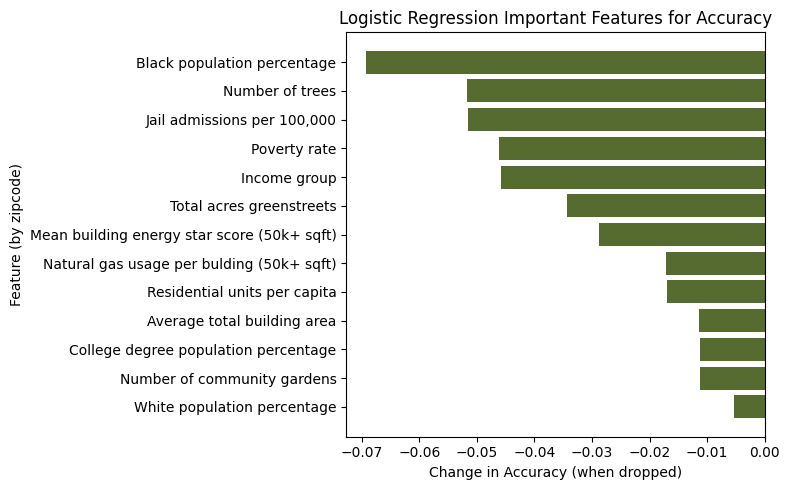

In [ ]:
acc_change_df = drop_results.sort_values(by='acc_change')
acc_change_df['feature_dropped'] = ['Black population percentage', 'Number of trees', 'Jail admissions per 100,000', 'Poverty rate', 'Income group',
                           'Total acres greenstreets', 'Mean building energy star score (50k+ sqft)', 'Natural gas usage per bulding (50k+ sqft)', 'Residential units per capita',
                           'Average total building area', 'College degree population percentage', 'Number of community gardens', 'White population percentage']

# plotting
plt.figure(figsize=(8, 5))
plt.barh(acc_change_df['feature_dropped'], acc_change_df['acc_change'], color = 'darkolivegreen')
plt.xlabel('Change in Accuracy (when dropped)')
plt.ylabel('Feature (by zipcode)')
plt.title('Logistic Regression Important Features for Accuracy')
plt.gca().invert_yaxis()  # So most important appears on top
# plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

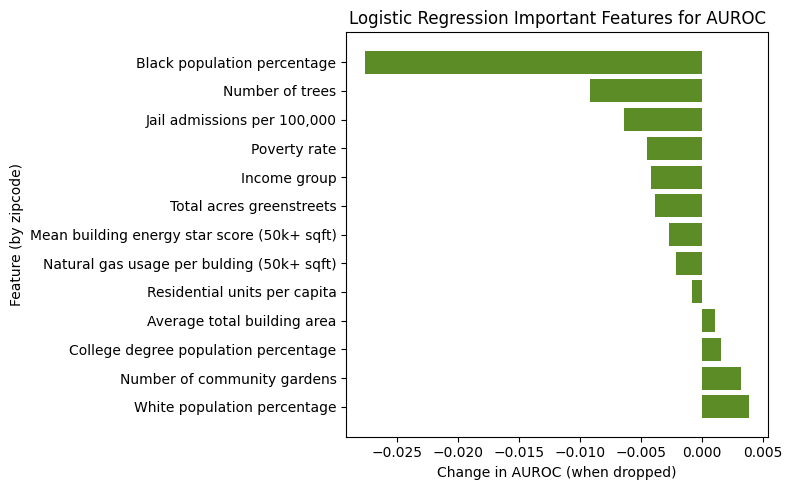

In [ ]:
auc_change_df = drop_results.sort_values(by='auc_change')
auc_change_df['feature_dropped'] = ['Black population percentage', 'Number of trees', 'Jail admissions per 100,000', 'Poverty rate', 'Income group',
                           'Total acres greenstreets', 'Mean building energy star score (50k+ sqft)', 'Natural gas usage per bulding (50k+ sqft)', 'Residential units per capita',
                           'Average total building area', 'College degree population percentage', 'Number of community gardens', 'White population percentage']

# plotting
plt.figure(figsize=(8, 5))
plt.barh(auc_change_df['feature_dropped'], auc_change_df['auc_change'], color = '#5c8c25')
plt.xlabel('Change in AUROC (when dropped)')
plt.ylabel('Feature (by zipcode)')
plt.title('Logistic Regression Important Features for AUROC')
plt.gca().invert_yaxis()  # So most important appears on top
# plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

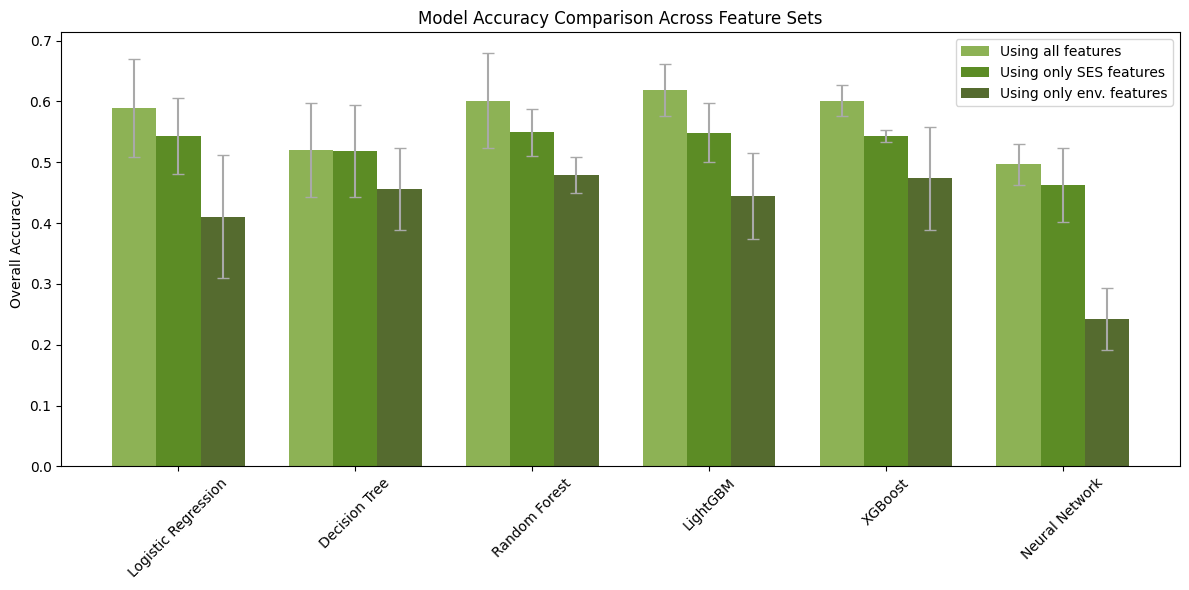

In [ ]:
# DataFrames list and labels
dfs = [both_results_df, ses_results_df, env_results_df]
labels = ['Using all features', 'Using only SES features', 'Using only env. features']

# Get model names (assumed same order in all dfs)
models = both_results_df['model'].tolist()
x = np.arange(len(models))  # model positions

# Bar width and setup
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]
colors = ['#8db255', '#5c8c25', 'darkolivegreen']

plt.figure(figsize=(12, 6))

for i, (df, label) in enumerate(zip(dfs, labels)):
    acc = df['overall_acc'].values
    std = df['overall_acc_std'].values
    plt.bar(x + offsets[i], acc, bar_width, yerr=std, capsize=4, error_kw=dict(ecolor='darkgray'), label=label, color=colors[i])

# Formatting
plt.xticks(x, models, rotation=45)
plt.ylabel('Overall Accuracy')
plt.title('Model Accuracy Comparison Across Feature Sets')
plt.legend()
plt.tight_layout()

plt.show()


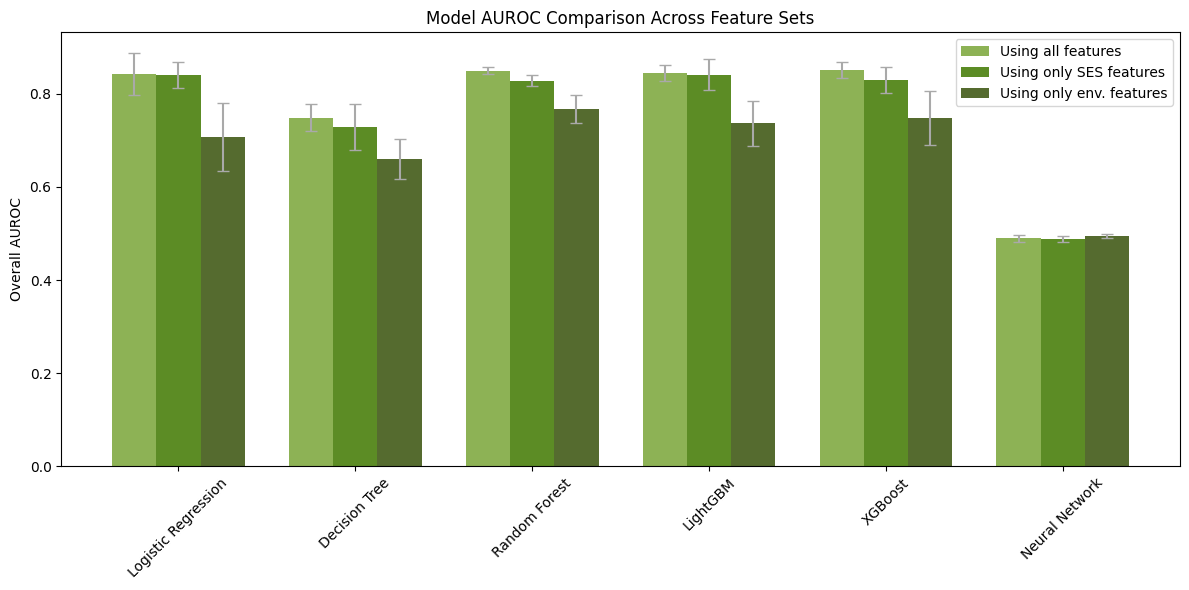

In [ ]:
# DataFrames list and labels
dfs = [both_results_df, ses_results_df, env_results_df]
labels = ['Using all features', 'Using only SES features', 'Using only env. features']

# Get model names (assumed same order in all dfs)
models = both_results_df['model'].tolist()
x = np.arange(len(models))  # model positions

# Bar width and setup
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]
colors = ['#8db255', '#5c8c25', 'darkolivegreen']

plt.figure(figsize=(12, 6))

for i, (df, label) in enumerate(zip(dfs, labels)):
    auc = df['overall_auroc'].values
    std = df['overall_auroc_std'].values
    plt.bar(x + offsets[i], auc, bar_width, yerr=std, capsize=4, error_kw=dict(ecolor='darkgray'), label=label, color=colors[i])

# Formatting
plt.xticks(x, models, rotation=45)
plt.ylabel('Overall AUROC')
plt.title('Model AUROC Comparison Across Feature Sets')
plt.legend()
plt.tight_layout()

plt.show()


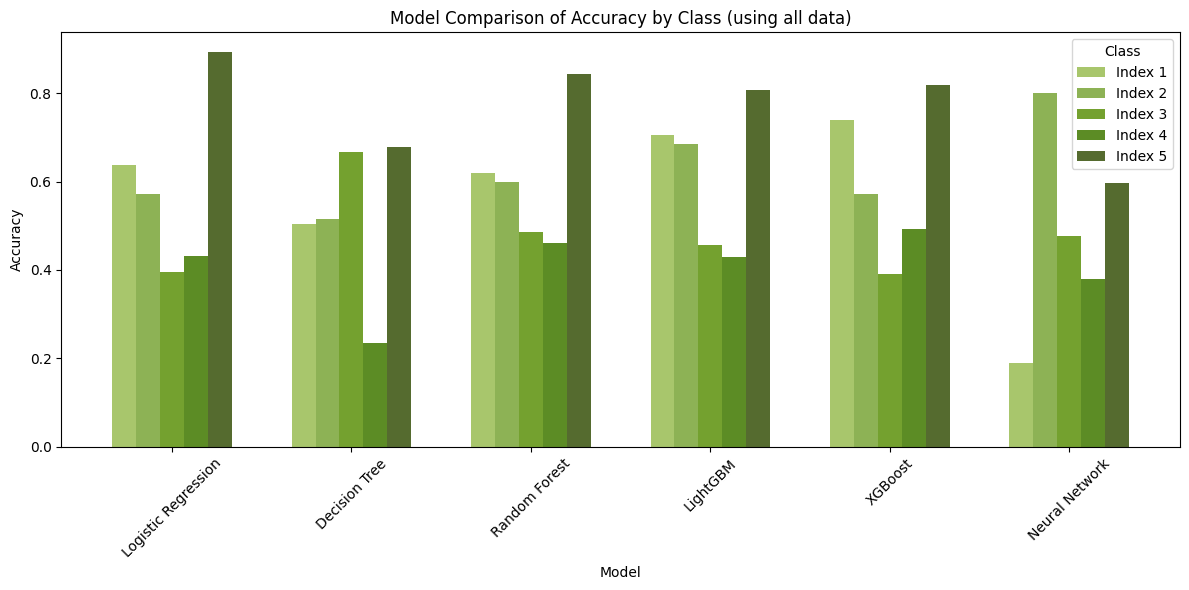

In [ ]:
# Prepare plot_df and replace NN row
plot_df = both_results_df[['model', 'class_1_acc', 'class_2_acc',
                           'class_3_acc', 'class_4_acc', 'class_5_acc']].copy()

# Set up wider x positions and bar width
x = np.arange(len(plot_df)) * 1.5  # <-- add spacing between clusters
bar_width = 0.2

# Define a custom color palette
colors = ['#a8c66c', '#8db255', '#74a12f', '#5c8c25', 'darkolivegreen']

# Create plot
plt.figure(figsize=(12, 6))
plt.bar(x - 2 * bar_width, plot_df['class_1_acc'], width=bar_width, label='Index 1', color=colors[0])
plt.bar(x - bar_width, plot_df['class_2_acc'], width=bar_width, label='Index 2', color=colors[1])
plt.bar(x, plot_df['class_3_acc'], width=bar_width, label='Index 3', color=colors[2])
plt.bar(x + bar_width, plot_df['class_4_acc'], width=bar_width, label='Index 4', color=colors[3])
plt.bar(x + 2 * bar_width, plot_df['class_5_acc'], width=bar_width, label='Index 5', color=colors[4])

# Formatting
plt.xticks(ticks=x, labels=plot_df['model'], rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Comparison of Accuracy by Class (using all data)')
plt.legend(title="Class")
plt.tight_layout()
plt.show()


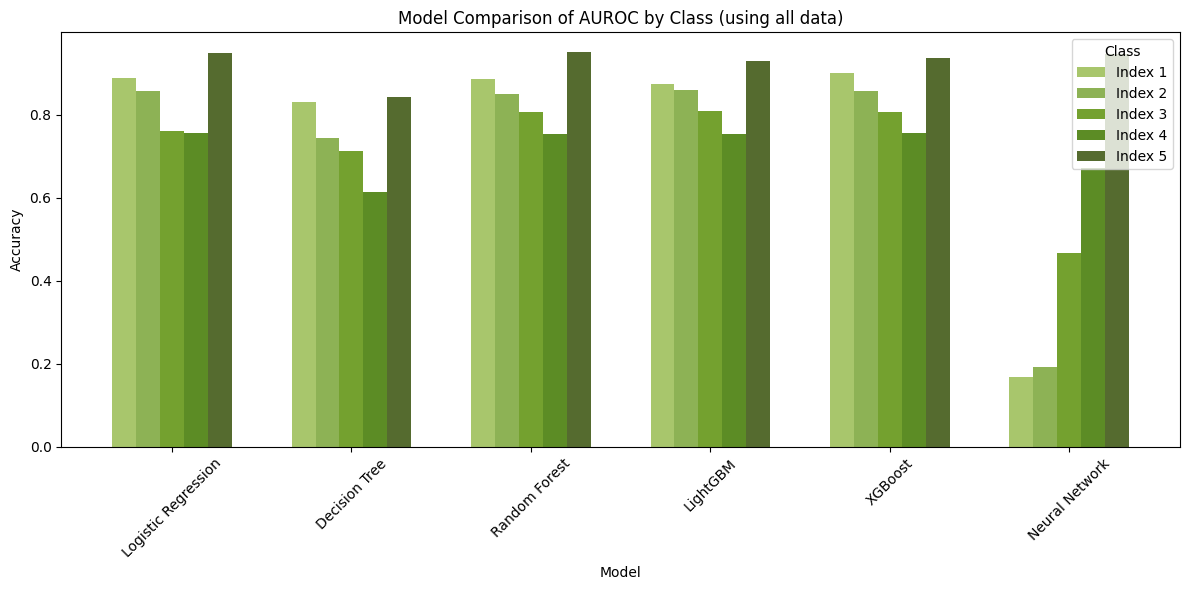

In [ ]:
# Prepare plot_df and replace NN row
plot_df = both_results_df[['model', 'class_1_auc', 'class_2_auc',
                           'class_3_auc', 'class_4_auc', 'class_5_auc']].copy()

# Set up wider x positions and bar width
x = np.arange(len(plot_df)) * 1.5  # <-- add spacing between clusters
bar_width = 0.2

# Define a custom color palette
colors = ['#a8c66c', '#8db255', '#74a12f', '#5c8c25', 'darkolivegreen']

# Create plot
plt.figure(figsize=(12, 6))
plt.bar(x - 2 * bar_width, plot_df['class_1_auc'], width=bar_width, label='Index 1', color=colors[0])
plt.bar(x - bar_width, plot_df['class_2_auc'], width=bar_width, label='Index 2', color=colors[1])
plt.bar(x, plot_df['class_3_auc'], width=bar_width, label='Index 3', color=colors[2])
plt.bar(x + bar_width, plot_df['class_4_auc'], width=bar_width, label='Index 4', color=colors[3])
plt.bar(x + 2 * bar_width, plot_df['class_5_auc'], width=bar_width, label='Index 5', color=colors[4])

# Formatting
plt.xticks(ticks=x, labels=plot_df['model'], rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Comparison of AUROC by Class (using all data)')
plt.legend(title="Class")
plt.tight_layout()
plt.show()
